In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
# kaggle data:
lap_times = pd.read_csv(r"F1_data\lap_times.csv")
drivers = pd.read_csv(r"F1_data\drivers.csv")
results = pd.read_csv(r"F1_data\results.csv")

# scraped data:
circuits = pd.read_csv(r"data_cleaned\circuits.csv")
races = pd.read_csv(r"data_cleaned\races.csv")
engines = pd.read_csv(r"data_cleaned\engines.csv")

# merged data:
teams = pd.read_csv(r"data_cleaned\teams.csv")
lap_speeds = pd.read_csv(r"data_cleaned\lap_speeds.csv")
main_drivers = pd.read_csv(r"data_cleaned\main_drivers .csv")
constructors = pd.read_csv(r"data_cleaned\constructors.csv")

### convert point system to be uniform over the years

In [3]:
points_map = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}

results['point_map'] = results['positionOrder'].map(points_map)
results['point_map'].fillna(0, inplace=True)
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,point_map
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,25.0
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,18.0
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,15.0
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,12.0
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,10.0


### Get all race winners

In [4]:
winners = results.loc[results.positionOrder ==1, ['raceId', 'constructorId']]
winners = winners.merge(races.loc[races.year > 1995, ['raceId', 'year']], on='raceId', how='left')
winners = winners.merge(constructors[['constructorId', 'constructorRef_mapped']], on ='constructorId', how='left')
winners = winners.merge(engines[['year', 'engine', 'constructorId']], how='left',
                        left_on=['constructorId', 'year'], 
                        right_on=['constructorId', 'year'])
winners.head()

,raceId,constructorId,year,constructorRef_mapped,engine
0,18,1,2008.0,mclaren,mercedes
1,19,6,2008.0,ferrari,ferrari
2,20,6,2008.0,ferrari,ferrari
3,21,6,2008.0,ferrari,ferrari
4,22,6,2008.0,ferrari,ferrari


### Get expected win count by engine

In [5]:
expected = results[['raceId', 'constructorId', 'grid']].copy()
expected = expected.merge(races.loc[races.year > 1995, ['raceId', 'year']], on='raceId', how='inner')
expected = expected.merge(constructors[['constructorId', 'constructorRef_mapped']], on ='constructorId', how='left')
expected = expected.merge(engines[['year', 'engine', 'constructorId', 'constructorRef']], how='left',
                        left_on=['constructorId', 'year'], 
                        right_on=['constructorId', 'year'])

engine_count  = pd.DataFrame({'engine_count' : expected.groupby(['engine', 'year'])['constructorId'].count()}).reset_index()
starter_count = pd.DataFrame({'starter_count' : expected.groupby(['year'])['constructorId'].count()}).reset_index()
race_count    = pd.DataFrame({'race_count' : expected.groupby(['year'])['raceId'].nunique()}).reset_index()
expected_vals = engine_count.merge(starter_count, how='left', on ='year')
expected_vals = expected_vals.merge(race_count, how='left', on ='year')
expected_vals['expected'] = expected_vals['engine_count']/expected_vals['starter_count']
expected_vals['expected wins'] = expected_vals['expected']*expected_vals['race_count']
expected_vals.head()

,engine,year,engine_count,starter_count,race_count,expected,expected wins
0,acer,2001,34,374,17,0.090909,1.545455
1,arrows,1998,32,349,16,0.091691,1.467049
2,arrows,1999,32,352,16,0.090909,1.454545
3,asiatech,2001,34,374,17,0.090909,1.545455
4,asiatech,2002,32,362,17,0.088398,1.502762


### Engine win count since 1996

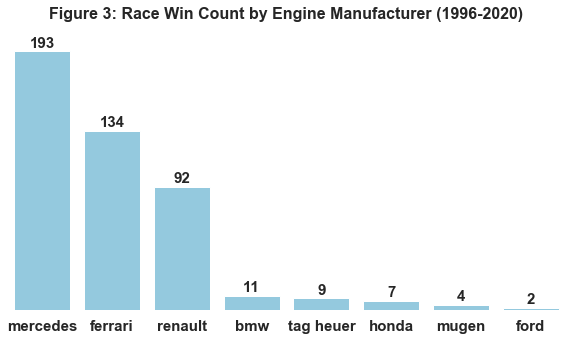

In [28]:
engine_wins = pd.DataFrame({'engine_win_count' : winners.groupby(['engine'])['raceId'].count()}).reset_index()\

sns.set(rc={'figure.figsize':(10,5)})
sns.set(style="white")

ax = sns.barplot(x='engine',
            y="engine_win_count", 
            data=engine_wins, 
            color='skyblue',
            order=engine_wins.sort_values('engine_win_count', ascending=False).engine)

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+3,
    s = '{:.0f}'.format(height), 
    ha = 'center',
    fontweight='bold',
    fontsize=15) 
    
ax.set_title('Figure 3: Race Win Count by Engine Manufacturer (1996-2020)', fontsize=16, fontweight='bold', y=1.05)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('')
plt.yticks([], [])

sns.despine(left=True, bottom=True)

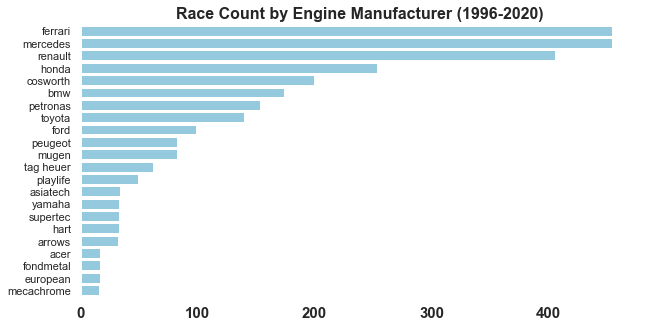

In [7]:
engine_count_all  = pd.DataFrame({'engine_count' : expected[expected.year>1995].groupby(['engine'])['raceId'].nunique()}).reset_index()

sns.set(rc={'figure.figsize':(10,5)})
sns.set(style="white")

ax = sns.barplot(y='engine',
            x="engine_count", 
            data=engine_count_all, 
            color='skyblue',
            orient='h',
            order=engine_count_all.sort_values('engine_count', ascending=False).engine)
    
ax.set_title('Race Count by Engine Manufacturer (1996-2020)', fontsize=16, fontweight='bold')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('')

sns.despine(left=True, bottom=True)

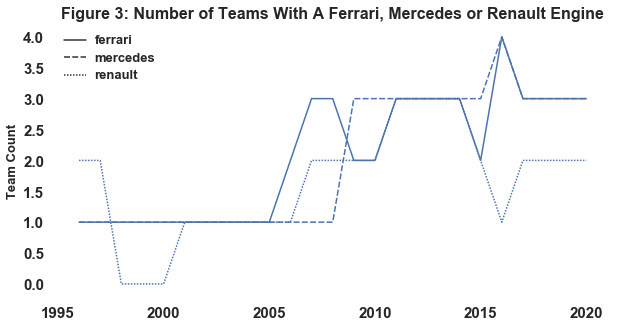

In [8]:
engine_count_top3 = pd.DataFrame({'engine_count' : expected.groupby(['engine', 'year'])['constructorId'].nunique()}).reset_index()
engine_count_top3 = engine_count_top3[engine_count_top3.engine.isin(['mercedes', 'ferrari', 'renault'])]

engine_count_top3_piv = pd.pivot_table(engine_count_top3, values="engine_count", index="year", columns="engine")
engine_count_top3_piv.fillna(0, inplace=True)
engine_count_top3 = engine_count_top3_piv.stack().reset_index(name='engine_count')

sns.set(rc={'figure.figsize':(10,5)})
sns.set(style="white")

ax = sns.lineplot(x='year',
            y="engine_count", 
            data=engine_count_top3,
            style='engine')
    
ax.set_title('Figure 3: Number of Teams With A Ferrari, Mercedes or Renault Engine', fontsize=16, fontweight='bold')
ax.set_ylabel('Team Count', fontsize=13, fontweight='bold')
plt.xlabel('')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='13', fontweight='bold') 

sns.despine(left=True, bottom=True)

In [9]:
df = lap_speeds[['raceId', 'year', 'driverId', 'lap', 'position', 'km_per_sec', 'km_per_min']].merge(races[['raceId', 'circuitId']], on ='raceId', how='left')
df = df.merge(teams[['raceId', 'driverId', 'constructorId', 'constructorRef_mapped']], on=['raceId', 'driverId'], how='left')
df = df.merge(circuits[['circuitId', 'circuitRef']], on='circuitId', how='left')
df = df.merge(engines[['year', 'engine', 'constructorId', 'constructorRef']], how='left',
                        left_on=['constructorId', 'year'], 
                        right_on=['constructorId', 'year'])
df.head()

,raceId,year,driverId,lap,position,km_per_sec,km_per_min,circuitId,constructorId,constructorRef_mapped,circuitRef,engine,constructorRef
0,1,2009,1.0,1.0,13.0,0.048612,2.916728,1,1,mclaren,albert_park,mercedes,mclaren
1,1,2009,1.0,2.0,12.0,0.056571,3.394282,1,1,mclaren,albert_park,mercedes,mclaren
2,1,2009,1.0,3.0,11.0,0.057893,3.473581,1,1,mclaren,albert_park,mercedes,mclaren
3,1,2009,1.0,4.0,10.0,0.058232,3.493911,1,1,mclaren,albert_park,mercedes,mclaren
4,1,2009,1.0,5.0,10.0,0.057561,3.453636,1,1,mclaren,albert_park,mercedes,mclaren


In [10]:
avg_lap_speed = pd.DataFrame({'avg_lap_speed' : df.groupby(['year', 'engine'])['km_per_min']
              .mean()}).sort_values(['engine', 'year']).reset_index()

avg_lap_speed = avg_lap_speed.sort_values(["engine","year"])
avg_lap_speed = avg_lap_speed[['year', 'engine', 'avg_lap_speed']].drop_duplicates()
avg_lap_speed_top3 = avg_lap_speed.loc[avg_lap_speed.engine.isin(['mercedes', 'ferrari', 'renault'])]
avg_lap_speed_top3.head()

,year,engine,avg_lap_speed
27,1996,ferrari,3.063188
28,1997,ferrari,3.162114
29,1998,ferrari,3.158278
30,1999,ferrari,3.165294
31,2000,ferrari,3.184019


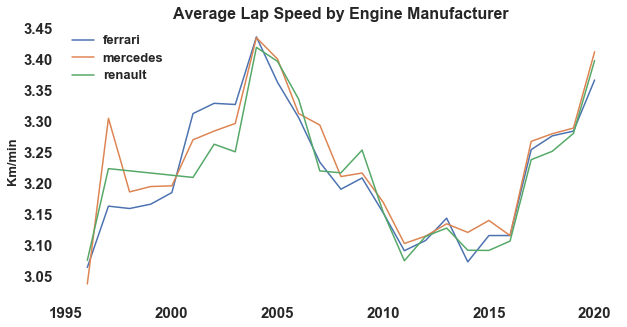

In [11]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set(style="white")

ax = sns.lineplot(x='year',
            y="avg_lap_speed", 
            data=avg_lap_speed_top3,
            hue='engine')
    
ax.set_title('Average Lap Speed by Engine Manufacturer', fontsize=16, fontweight='bold')
ax.set_ylabel('Km/min', fontsize=13, fontweight='bold')
plt.xlabel('')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='13', fontweight='bold') 

sns.despine(left=True, bottom=True)

In [12]:
points = results[['raceId', 'constructorId', 'point_map']].copy()
points = points.merge(races.loc[races.year > 1995, ['raceId', 'year']], on='raceId', how='left')
points = points.merge(constructors[['constructorId', 'constructorRef_mapped']], on ='constructorId', how='left')
points = points.merge(engines[['year', 'engine', 'constructorId']], how='left',
                        left_on=['constructorId', 'year'], 
                        right_on=['constructorId', 'year'])

engine_points = pd.DataFrame({'engine_point_sum' : points.groupby(['engine', 'year'])['point_map'].sum()}).reset_index()
engine_points_top3 = engine_points.loc[engine_points.engine.isin(['mercedes', 'ferrari', 'renault'])]
engine_points_top3 = engine_points_top3.merge(engine_count, on =['year', 'engine'], how='left')
engine_points_top3["point_avg"] = engine_points_top3["engine_point_sum"]/engine_points_top3["engine_count"]
engine_points_top3

,engine,year,engine_point_sum,engine_count,point_avg
0,ferrari,1996.0,232.0,32,7.250000
1,ferrari,1997.0,324.0,34,9.529412
2,ferrari,1998.0,416.0,32,13.000000
3,ferrari,1999.0,411.0,32,12.843750
4,ferrari,2000.0,491.0,34,14.441176
5,ferrari,2001.0,522.0,34,15.352941
6,ferrari,2002.0,603.0,34,17.735294
7,ferrari,2003.0,399.0,32,12.468750
8,ferrari,2004.0,638.0,36,17.722222
9,ferrari,2005.0,256.0,38,6.736842


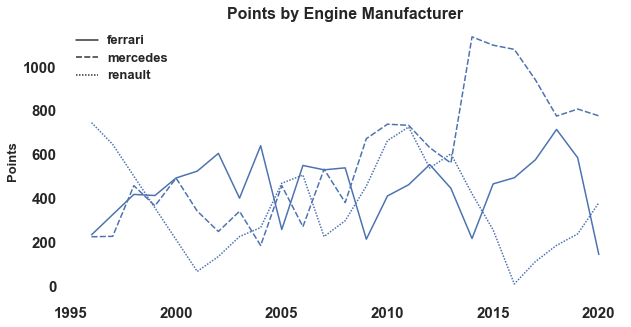

In [13]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set(style="white")

ax = sns.lineplot(x='year',
            y="engine_point_sum", 
            data=engine_points_top3,
            style='engine')
    
ax.set_title('Points by Engine Manufacturer', fontsize=16, fontweight='bold')
ax.set_ylabel('Points', fontsize=13, fontweight='bold')
plt.xlabel('')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='13', fontweight='bold') 

sns.despine(left=True, bottom=True)

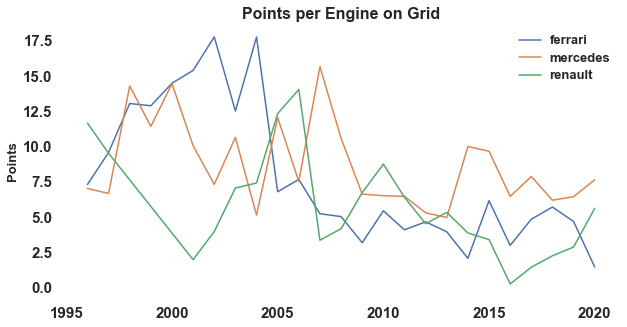

In [14]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set(style="white")

ax = sns.lineplot(x='year',
            y="point_avg", 
            data=engine_points_top3,
            hue='engine')
    
ax.set_title('Points per Engine on Grid', fontsize=16, fontweight='bold')
ax.set_ylabel('Points', fontsize=13, fontweight='bold')
plt.xlabel('')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='13', fontweight='bold') 

sns.despine(left=True, bottom=True)

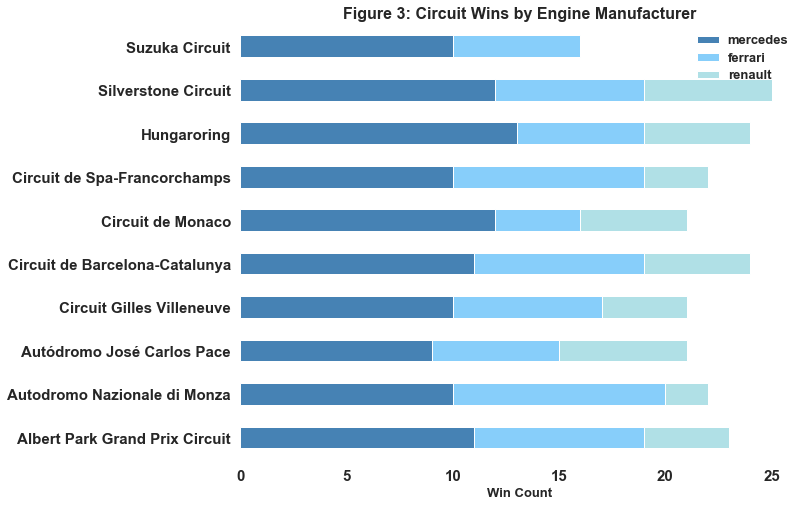

In [27]:
circuit_results = results.merge(races[['raceId', 'year', 'circuitId']], how='left', on ='raceId')
circuit_results = circuit_results.merge(circuits[['circuitId', 'name']], how='left', on ='circuitId')

circuit_results = circuit_results[['raceId', 'constructorId', 'point_map', 'name']].copy()
circuit_results = circuit_results.merge(races.loc[races.year > 1995, ['raceId', 'year']], on='raceId', how='left')
circuit_results = circuit_results.merge(constructors[['constructorId', 'constructorRef_mapped']], on ='constructorId', how='left')
circuit_results = circuit_results.merge(engines[['year', 'engine', 'constructorId']], how='left',
                        left_on=['constructorId', 'year'], 
                        right_on=['constructorId', 'year'])

circuit_count = pd.DataFrame({'circuit_count' : circuit_results[circuit_results.year > 1995].groupby(['name', 'engine'])['raceId'].nunique()}).reset_index()
circuit_count = circuit_count.sort_values(['engine', 'circuit_count'])

circuit_results_winners = circuit_results[(circuit_results.point_map == 25) & (circuit_results.year > 1995)].copy()
circuit_results_winners = pd.DataFrame({'circuit_win_count' : circuit_results_winners.groupby(['name', 'engine'])['raceId'].count()}).reset_index()

circuit_results_winners.sort_values(['name', 'circuit_win_count'])

circuit_props = circuit_results_winners.merge(circuit_count)
circuit_props['prop_wins'] = (circuit_props['circuit_win_count']*100/circuit_props['circuit_count']).round()
circuit_props[circuit_props.circuit_count >19].sort_values(['name', 'prop_wins'])

circuit_results_winners_piv = pd.pivot_table(circuit_props[circuit_props.circuit_count >19], values="circuit_win_count", index="name", columns="engine")
circuit_results_winners_piv.fillna(0, inplace=True)
circuit_results_winners_piv = circuit_results_winners_piv[["mercedes", "ferrari", "renault"]]

sns.set(rc={'figure.figsize':(10,8)})
sns.set(style="white")

ax = circuit_results_winners_piv.plot.barh(stacked=True, color=['steelblue', 'lightskyblue', 'powderblue'])

ax.set_title('Figure 3: Circuit Wins by Engine Manufacturer', fontsize=16, fontweight='bold')
ax.set_xlabel('Win Count', fontsize=13, fontweight='bold')
plt.ylabel('')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

handles, labels = ax.get_legend_handles_labels()
ax.legend(frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='13', fontweight='bold') 

sns.despine(left=True, bottom=True)



### Focus on top 3 engines

In [18]:
top3 = winners.loc[winners.engine.isin(['mercedes', 'ferrari', 'renault'])]
top3_exp = expected_vals.loc[expected_vals.engine.isin(['mercedes', 'ferrari', 'renault'])]

top3_win_count = pd.DataFrame({'engine_win_count' : top3.groupby(['engine', 'year'])['raceId'].count()}).reset_index()\

top3_piv = pd.pivot_table(top3_win_count, values="engine_win_count", index="year", columns="engine")
top3_exp_piv = pd.pivot_table(top3_exp, values="expected wins", index="year", columns="engine")

top3_piv.fillna(0, inplace=True)
top3_exp_piv.fillna(0, inplace=True)

top3 = top3_piv.stack().reset_index(name='engine_win_count')
top3_exp = top3_exp_piv.stack().reset_index(name='expected wins')

In [19]:
top3.head()

,year,engine,engine_win_count
0,1996.0,ferrari,3.0
1,1996.0,mercedes,0.0
2,1996.0,renault,12.0
3,1997.0,ferrari,5.0
4,1997.0,mercedes,3.0


In [20]:
top3_exp.head()

,year,engine,expected wins
0,1996,ferrari,1.505882
1,1996,mercedes,1.505882
2,1996,renault,3.011765
3,1997,ferrari,1.537234
4,1997,mercedes,1.537234


In [21]:
#d73027 #fee090, #91bfdb
col_map = {'mercedes': 'royalBlue',
          'renault': 'goldenrod',
          'ferrari': 'firebrick'}

line_map = {'mercedes': 'dot',
            'renault': 'dash',
            'ferrari': 'solid'}

pointer_map = {'mercedes': 'triangle-up',
               'renault': 'diamond',
               'ferrari': 'circle'}

outline_map = {'mercedes': 'white',
               'renault': 'black',
               'ferrari': 'black'}

name_map = {'mercedes': 'Mercedes',
               'renault': 'Renault',
               'ferrari': 'Ferrari'}

In [22]:
import base64
with open("logos/ferrari.png", "rb") as image_file_ferrari:
    encoded_string = base64.b64encode(image_file_ferrari.read()).decode()
# Add the prefix that plotly will want when using the string as source
encoded_image_ferrari = "data:image/png;base64," + encoded_string

with open("logos/mercedes.png", "rb") as image_file_mercedes:
    encoded_string = base64.b64encode(image_file_mercedes.read()).decode()
# Add the prefix that plotly will want when using the string as source
encoded_image_mercedes = "data:image/png;base64," + encoded_string

with open("logos/renault.png", "rb") as image_file_renault:
    encoded_string = base64.b64encode(image_file_renault.read()).decode()
encoded_image_renault = "data:image/png;base64," + encoded_string


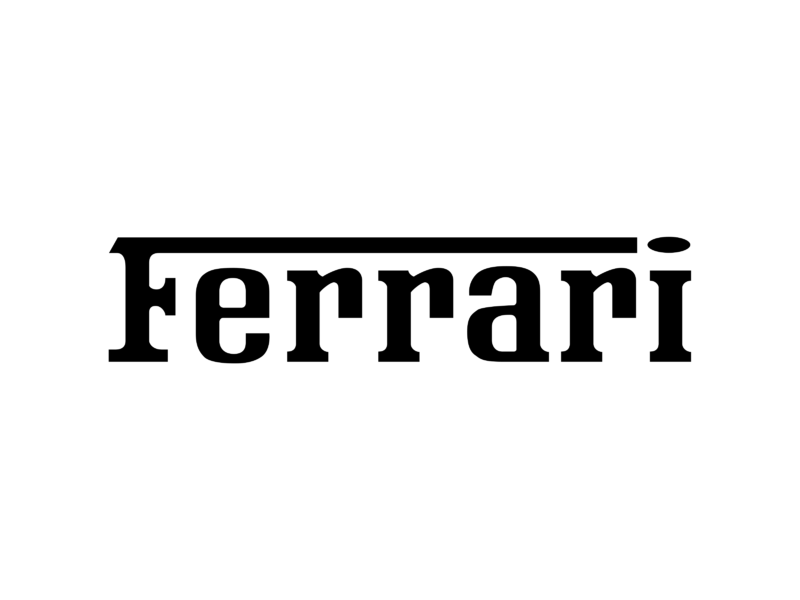
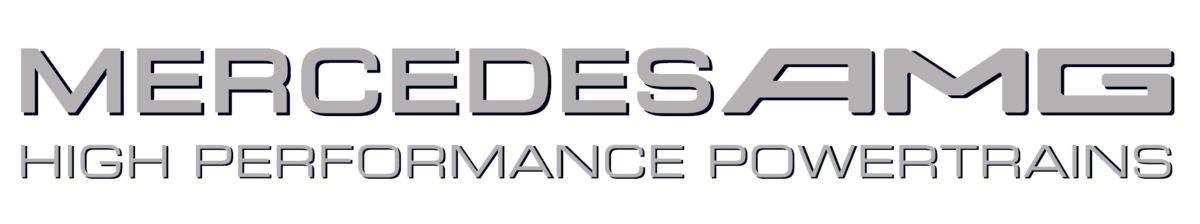
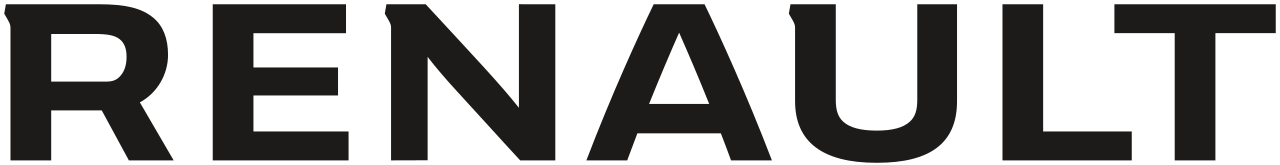

In [26]:
df = top3
df_exp = top3_exp
df_count = engine_count_top3

fig = make_subplots(rows=3, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                    #subplot_titles=('<b>Ferrari</b>', '<b>Mercedes</b>', '<b>Renault</b>')
)

i=1
ypos = [0.95, 0.6, 0.25]

for engine in df['engine'].unique():
    
    leg_bool=True
    tl=10
    xtitle="<b>Year</b>"
    ytitle=""
    if i<3:
        leg_bool=False
        tl=0
        xtitle=""
    if i ==2:
        ytitle="<b>Win Count</b>"
        
    df1 = df.loc[df.engine == engine,:]
    fig.add_trace(go.Bar(
        x=df1['year'],
        y=df1['engine_win_count'],
        name=name_map[engine],
        marker_color=col_map[engine],
        hovertemplate =
                     '<b>Year: :</b> %{x} <br>' +
                     '<b>Win Count: </b>%{y}<extra></extra>',
        showlegend=False
    ), row=i, col=1)
    
    df2 = df_exp.loc[df_exp.engine == engine,:]
    fig.add_trace(go.Scatter(
        x=df2['year'],
        y=df2['expected wins'],
        mode='lines+markers',
        line=dict(color='black', dash='dash', width=2),
        marker = dict(symbol='circle', size=5),
        name='<b>Expected Win Count</b>',
        hovertemplate =
                     '<b>Year: :</b> %{x} <br>' +
                     '<b>Teams With Engine: </b>%{text}<br>' +
                     '<b>Expected Win Count: </b>%{y}<extra></extra>',
        text = df_count.loc[(df_count.engine == engine), "engine_count"],
        showlegend=leg_bool
    ), row=i, col=1)
    
    fig.update_yaxes(
            range=[0,20.5],
            title_text=ytitle,
            tickwidth=2,
            ticks="outside",
            ticklen=10,
            tickprefix="<b>",ticksuffix ="</b>",
            tickfont=dict(size=15),
            showline=True,
            linewidth=2,
            linecolor='black',
            gridcolor='lightGray', 
            row=i,col=1),
        
    fig.update_xaxes(
            range=[1995,2020.5],
            tick0=1996,
            dtick=2,
            title_text=xtitle,
            tickwidth=2,
            ticks="outside",
            tickprefix="<b>",ticksuffix ="</b>",
            ticklen=tl,
            showline=True,
            linewidth=2,
            linecolor='black',
            row=i,col=1),
    
    #fig.layout.annotations[i-1].update(x=0.02, y=ypos[i-1], xanchor='left', font=dict(size=20))
    
    i=i+1


fig.add_vrect(
    x0="1995", x1="2005.5",
    fillcolor="azure",  # opacity=0.5,
    layer="below", line_width=0,
),

fig.add_vrect(
    x0="2005.5", x1="2013.5",
    fillcolor="cornsilk",  # opacity=0.5,
    layer="below", line_width=0,
),

fig.add_vrect(
    x0="2013.5", x1="2021",
    fillcolor="honeydew",  # opacity=0.5,
    layer="below", line_width=0,
),

fig.add_annotation(x=2005.5, y=17,
                   xref="x", yref="y", ax=1995.5, ay=17,
                   axref="x", ayref="y",
                   arrowhead=5, arrowside="end+start", arrowsize=1.5, arrowcolor='teal')

fig.add_annotation(x=2000.5, y=18.5, text="<b>V10/12 Engines</b>",
                   showarrow=False, font=dict(size=18, color='teal'))

fig.add_annotation(x=2005.5, y=17,
                   xref="x", yref="y", ax=2013.5, ay=17,
                   axref="x", ayref="y",
                   arrowhead=5, arrowside="end+start", arrowsize=1.5, arrowcolor='IndianRed')

fig.add_annotation(x=2009.5, y=18.5, text="<b>V8 Engines</b>",
                   showarrow=False, font=dict(size=18, color='IndianRed'))

fig.add_annotation(x=2020.5, y=17,
                   xref="x", yref="y", ax=2013.5, ay=17,
                   axref="x", ayref="y",
                   arrowhead=5, arrowside="end+start", arrowsize=1.5, arrowcolor='darkgreen')

fig.add_annotation(x=2017, y=18.5, text="<b>V6 Hybrid Engines</b>",
                   showarrow=False, font=dict(size=18, color='darkgreen'))


fig.add_layout_image(
    dict(
        source=encoded_image_ferrari,
        xref="paper", yref="paper",
        x=0.15, y=0.84,
        sizex=0.15, sizey=0.15,
        xanchor="right", yanchor="bottom"
    )
)

fig.add_layout_image(
    dict(
        source=encoded_image_mercedes,
        xref="paper", yref="paper",
        x=0.22, y=0.57,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)

fig.add_layout_image(
    dict(
        source=encoded_image_renault,
        xref="paper", yref="paper",
        x=0.17, y=0.23,
        sizex=0.15, sizey=0.15,
        xanchor="right", yanchor="bottom"
    )
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    
    plot_bgcolor='rgba(0,0,0,0)',
    
    title = dict(
        text="<b>F1 Grand Prix Wins by Engine Manufacturer </b>",
        xanchor='left',
        yanchor='top',
        y=0.92,
        x=0.1
    ),
    
    legend=dict(
        orientation="h",
        yanchor="bottom", y=1.02,
        xanchor="right", x=1
    ),
    
    font=dict(
        size=15,
    color='black')
)
    


    
fig.show()

